# Recurrent Neural Network (RNN) LSTM based Sentiment Analysis

In this we use LSTM (Long Short Term Memory) perceptron and use a neural network model to model sentiments based on inout word tokens and bigrams

In [1]:

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('pymodules')

# Gensim
from gensim.models import Word2Vec
# making the plot look good ...
from adjustText import adjust_text
from sklearn.decomposition import PCA

from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional
from tensorflow.keras.layers import Dropout

from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn import metrics
from sklearn.model_selection import train_test_split, ParameterGrid

# this class read the raw input and tokenizes comprehensively for use with modeling
import pymodules.read_and_tokenize as contacts_utils

from timeit import default_timer as timer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/Users/bmukund/miniconda3/lib/python3.8/site-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.3.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


### Read file and preprocess to generate tokens

In [2]:
filename = "data/Master-data_Q42021.xlsx"
prep_comments, df = contacts_utils.read_file(filename)

Read sheet 'Scrubbed_data' ...
Columns:Index(['TITLE', 'COMMENTS', 'OVERALL_RATING', 'COMFORT_RATING',
       'VISION_RATING', 'VALUE_FOR_MONEY', 'AUTHOR', 'PROS', 'CONS',
       'ORIGINAL_SOURCE', 'REPLY_FROM_ACCUVUE', 'FINAL_PRODUCT_NAME',
       'PRODUCT_LINK', 'WEBSITE', 'RATING', 'PRODUCT', 'BRAND'],
      dtype='object')
Columns dropped: ['OVERALL_RATING', 'COMFORT_RATING', 'VISION_RATING', 'VALUE_FOR_MONEY', 'PROS', 'CONS', 'ORIGINAL_SOURCE', 'REPLY_FROM_ACCUVUE', 'PRODUCT_LINK', 'WEBSITE']
 Drop the Author column and replace it with gender of author ...
Consolidate all the comments into one column called COMMENT
Make ratings into integers
Tokenize data based on regex found from experimentation and common usage ...
Comments before tokenization at index[0]:
 Acucue 2 Contact Lenses I have used these lenses for a long time and I have to say that the service from Lens.com is great and the lenses work great for my needs!  I highly recommend them!
Comments after tokenization at index

### Determine response variable called 'SENTIMENT' based on rating

* If Rating is < 3, we give a sentiment value of 0 (Negative sentiment)

* If Rating is = 3, we give a sentiment value of 1 (Neutral sentiment)

* If Rating is > 3, we give a sentiment value of 2 (Positive sentiment)

In [3]:
# attach sentiment, seems
def find_sentiment(rating):
    choices = [0, 1, 2]
    conditions = [rating < 3, rating == 3, rating > 3]
    senti = np.select(conditions, choices)
    return senti

df['SENTIMENT'] = df['RATING'].apply(find_sentiment).astype('category')

### Add bigrams to the word tokens so that sentiments are expressed better by word tokens and word-pairs

In [4]:
require_bigrams = True
if require_bigrams:
    for i in range(len(prep_comments.tokens)):
        prep_comments.tokens[i] = prep_comments.tokens[i] + prep_comments.bigrams[i]

test_index = 0
print(f"Comments at index[{test_index}] after addition of bigrams:\n {prep_comments.tokens[test_index]}")
print(f"Comments at index[{-1}] after addition of bigrams:\n {prep_comments.tokens[-1]}")

Comments at index[0] after addition of bigrams:
 ['used', 'for', 'long', 'time', 'and', 'say', 'service', 'from', 'com', 'great', 'and', 'work', 'great', 'for', 'needs', 'highly', 'recommend', 'used-for', 'for-long', 'long-time', 'time-and', 'and-say', 'say-service', 'service-from', 'from-com', 'com-great', 'great-and', 'and-work', 'work-great', 'great-for', 'for-needs', 'needs-highly', 'highly-recommend']
Comments at index[-1] after addition of bigrams:
 ['buy', 'again', 'order', 'came', 'fast', 'without', 'any', 'issues', 'and', 'candy', 'nice', 'touch', 'buy-again', 'again-order', 'order-came', 'came-fast', 'fast-without', 'without-any', 'any-issues', 'issues-and', 'and-candy', 'candy-nice', 'nice-touch']


In [5]:
## Create Dictionary
#id2word = corpora.Dictionary(prep_comments.tokens)
## Create Corpus: Term Document Frequency
#corpus = [id2word.doc2bow(text) for text in prep_comments.tokens]
#print(corpus)

### Add the token and Sentiments are new columns and display them

In [6]:
df['TOKENS'] = prep_comments.tokens

In [7]:
dfXY = df[['TOKENS', 'SENTIMENT']]

In [8]:
dfXY

,TOKENS,SENTIMENT
REVIEW_DATE,,
2021-11-01,"[used, for, long, time, and, say, service, fro...",2
2021-12-02,"[clear, vision, tends, cloud, clear-vision, vi...",2
2021-12-01,"[comfort, very, hard, handle, flimsy, but, com...",2
2021-11-16,"[easy, use, using, product, for, and, very, re...",2
2021-12-08,"[excellent, excellent, got, promised, discount...",2
...,...,...
2021-11-29,"[truly, best, price, fast, shipping, quick, ve...",2
2021-11-23,"[very, comfortable, vita, very, comfortable, a...",2
2021-12-27,"[very, comfortable, and, convenient, very, com...",2


### Showcase the imbalanced nature of Sentiments in the given data

[[Text(0, 0, '>3'), Text(1, 0, '<3'), Text(2, 0, '=3')]]

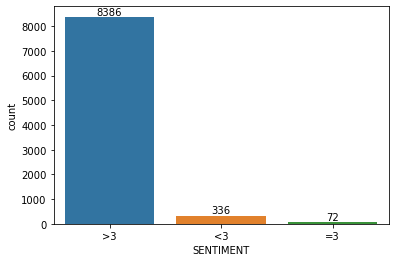

In [9]:
import seaborn as sns
ax = sns.countplot(x=dfXY['SENTIMENT'], order=dfXY['SENTIMENT'].value_counts(ascending=False).index)
abs_values = dfXY['SENTIMENT'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set(xticklabels=['>3', '<3', '=3'])

### Highly imbalanced data
* Because of highly imbalanced data, we need to "balance" by using class weights while fitting any model

## Use Keras engine for tokenization and also for RNN

### Take tokenized sentences and make it all integers using keras tokenizer on already tokenized data

In [10]:
# because embedding is independent of tokenization, we integerize our token based on keras tokenizer
num_expected_unique_words = 10000
keras_tokenizer = Tokenizer(num_expected_unique_words, split=",")
keras_tokenizer.fit_on_texts(dfXY['TOKENS'])

### Test, train, validation split

In [11]:
validation_reqd = True
X = dfXY.TOKENS
y = dfXY.SENTIMENT
df_trainX, df_trainy, df_testX, df_testy, df_validX, df_validy = contacts_utils.split_data(X, y, validation_reqd)

### Prepare data for input to RNN
* We pad the data so that the sequence length that goes into RNN is always the same (Usually this is not the case), which is set to 300
    * This sequence length is arbitrary and can be parameterized

In [12]:
MAX_SEQ_LEN = 300
X_train=keras_tokenizer.texts_to_sequences(df_trainX) # this converts texts into some numeric sequences
X_train_pad=pad_sequences(X_train,maxlen=MAX_SEQ_LEN,padding='post') # this makes the length of all numeric sequences equal

X_test = keras_tokenizer.texts_to_sequences(df_testX)
X_test_pad = pad_sequences(X_test, maxlen = MAX_SEQ_LEN, padding = 'post')

if validation_reqd:
    X_val = keras_tokenizer.texts_to_sequences(df_validX)
    X_val_pad = pad_sequences(X_val, maxlen = MAX_SEQ_LEN, padding = 'post')
else:
    X_val = None
    X_val_pad = None

In [13]:
y_train = to_categorical(df_trainy.values,num_classes=3)
y_test = to_categorical(df_testy.values, num_classes=3)
if validation_reqd:
    y_val = to_categorical(df_validy.values, num_classes=3)
else:
    y_val = None

### Balance imbalanced data using class weights 
Compute sentiment class weights based on training data to balance the dataset

In [14]:
from sklearn.utils.class_weight import compute_class_weight
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
sentiment_class_weights = dict(enumerate(class_weights))

{0: 7.460030165912519, 1: 34.34722222222222, 2: 0.3525051671299266}


/Users/bmukund/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


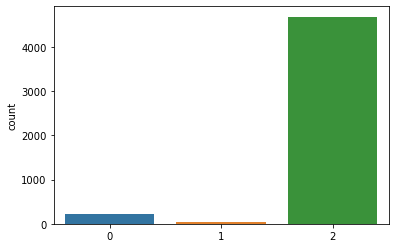

[ 221   48 4677]


/Users/bmukund/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


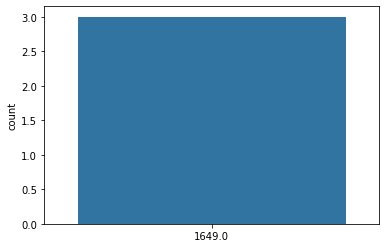

In [15]:
### Test if balancing has indeed taken place ...
print(sentiment_class_weights)
sns.countplot(y_integers)
plt.show()
print(np.bincount(y_integers))
balance_wts = np.array([val for k, val in sentiment_class_weights.items()])
bal = np.round(np.bincount(y_integers) * balance_wts)
sns.countplot(bal)
plt.show()

### Train gensim model to generate word embeddings made of 100 dimensional vector
* Word embeddings vector is of size 100
* It is based on universal dictionary
* Each word/token now is expressed as a vector of 100 arbitrary, deterministic features. i.e. a word is embedded in a $R^{100}$ basis space

In [16]:
# train Gensim's Word2Vec model
gensim_model = Word2Vec(sentences=prep_comments.tokens,      # corpus
                        vector_size=100,            # embedding dimension
                        window=4,                   # words before and after to take into consideration
                        sg=1,                       # use skip-gram
                        negative=5,                 # number of negative examples for each positive one
                        alpha=0.025,                # initial learning rate
                        min_alpha=0.0001,           # minimum learning rate
                        epochs=10,                   # number of passes through the data
                        min_count=1,                # words that appear less than this are removed
                        workers=4,                  # we use 1 to ensure replicability
                        seed=92                     # for replicability
                        )

### Do some gensim validation to ensure that word embeddings have been generated

In [17]:
# extract the word embeddings from the model
word_vectors = gensim_model.wv
word_vectors.vectors.shape  # vocab_size x embeddings dimension

(33417, 100)

In [18]:
word_vectors_weights = gensim_model.wv.vectors
vocab_size, embedding_size = word_vectors_weights.shape
print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

Vocabulary Size: 33417 - Embedding Dim: 100


In [19]:
# Some validation on the quality of the Word2Vec model
print(gensim_model.wv.most_similar('product', topn=3))
print(gensim_model.wv.most_similar('price', topn=3))
print(gensim_model.wv.most_similar('service', topn=3))
print(gensim_model.wv.most_similar('quality', topn=3))
print(gensim_model.wv.most_similar(positive=['comfort', 'fit'], negative=['dry'], topn=3))

def word2token(word):
    try:
        return gensim_model.wv.key_to_index[word]
    except KeyError:
        return 0

def token2word(token):
    return gensim_model.wv.index_to_key[token]

[('product-excellent', 0.8487588763237), ('complaints', 0.845560610294342), ('excellent-excellent', 0.8437972664833069)]
[('reasonable', 0.8621415495872498), ('deal', 0.8557785153388977), ('inexpensive', 0.8554325103759766)]
[('prompt', 0.9275981783866882), ('support', 0.9168749451637268), ('services', 0.9093946814537048)]
[('inexpensive', 0.9004871845245361), ('high', 0.8821184635162354), ('consistent', 0.8811280727386475)]
[('clarity-and', 0.779310405254364), ('comfort-clarity', 0.7789759635925293), ('and-comfort', 0.7742425203323364)]


In [20]:
gensim_weight_matrix = np.zeros((num_expected_unique_words ,embedding_size))
gensim_weight_matrix.shape

(10000, 100)

### Encode word embeddings
* Test key to index for word vectors, so we can go back and forth between word and its embedding

In [21]:
word_vectors[word_vectors.key_to_index['dry']]

array([-1.0567551 ,  0.5794932 ,  0.04696224,  1.0849292 , -0.70392257,
        0.58469963, -0.5408199 ,  0.5112359 ,  0.06947376,  0.01574691,
        0.8027163 ,  0.1808152 , -0.0240392 , -0.05469049, -0.3358213 ,
       -0.56312686, -0.31741065, -0.32615995,  0.4807728 , -1.1633352 ,
        1.0238576 , -0.53013396, -0.05519943,  0.05840091,  0.20794512,
       -0.11283576,  0.3075843 , -0.13057749,  0.19371147,  0.3644337 ,
        0.56170857,  0.66923803, -0.85273945,  0.19719815,  0.5979246 ,
        0.54743814,  0.45307067,  0.26919052,  0.54672194, -0.63489455,
        0.5374036 , -0.14397381, -0.5387951 , -0.00705698,  0.08561787,
        0.72511226,  0.25593624,  0.02148348, -0.32282192, -0.03039818,
        1.0585194 ,  0.03566016, -0.03193273, -0.17561074, -0.5770317 ,
       -0.04222794, -0.16787149,  0.7646237 ,  0.71381736, -0.5433788 ,
       -1.1929808 ,  1.6079367 , -0.5554333 ,  0.8199882 ,  0.2986765 ,
       -0.30615178,  0.17396073, -1.1024452 , -0.06520268, -0.81

### Map the index of the word (obtained by keras_tokenizer, which assigned interger values to words) to its weight matrix obtained from word embedding

In [22]:
for word, index in keras_tokenizer.word_index.items():
    if index < num_expected_unique_words: # why ? since index starts with zero
        try:
            word_index_in_embedding = word_vectors.key_to_index[word]
        except KeyError:
            gensim_weight_matrix[index] = np.zeros(embedding_size)
        else:
            gensim_weight_matrix[index] = word_vectors[word_index_in_embedding]

In [23]:
gensim_weight_matrix.shape

(10000, 100)

### RNN model

In [24]:
num_sentiments  = 3

### Cache results of RNN model in sentiment_RNN_Model.h5

In [25]:
#EarlyStopping and ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./sentiment_RNN_model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

### The RNN model

* 3 hidden layers

* loss function is "categorical cross entropy" as the sentiments are categorical

In [26]:
def create_RNN_model(num_sentiments, sentiment_class_weights, num_expected_unique_words, embedding_size, gensim_weight_matrix, trainX, trainy, validX, validy, testX, testy):
    def _create_RNN_model(param_dict):
        _epochs = param_dict['epochs']
        _batch_size = param_dict['batch_size']
        drop_out_factor = param_dict['drop_out_factor']
        lstm_nodes = param_dict['lstm_nodes']

        # fixed three layers ...
        model = Sequential()
        model.add(Embedding(input_dim = num_expected_unique_words,
                    output_dim = embedding_size,
                    input_length= trainX.shape[1],
                    weights = [gensim_weight_matrix],
                    trainable = False))

        model.add(Dropout(drop_out_factor[0]))
        model.add(Bidirectional(LSTM(lstm_nodes[0],return_sequences=True)))
        model.add(Dropout(drop_out_factor[1]))
        model.add(Bidirectional(LSTM(lstm_nodes[1],return_sequences=True)))
        model.add(Dropout(drop_out_factor[2]))
        model.add(Bidirectional(LSTM(lstm_nodes[2],return_sequences=False)))

        model.add(Dense(num_sentiments, activation = 'softmax'))

        model.compile(loss = 'categorical_crossentropy',
                      optimizer = 'adam',
                      metrics = 'accuracy')

        history = model.fit(trainX, trainy,
                            epochs = _epochs,
                            batch_size = _batch_size,
                            validation_data=(validX, validy),
                            verbose = 1,
                            callbacks= [es, mc],
                            class_weight = sentiment_class_weights,
                            workers=4,
                            use_multiprocessing=True)

        _, test_score = model.evaluate(testX,testy)
        y_pred_test_raw = model.predict(testX, workers=4, use_multiprocessing=True)
        y_test_pred = np.argmax(y_pred_test_raw, axis = 1)
        return test_score, param_dict, history, y_test_pred, model

    return _create_RNN_model

### Model parameterization

In [27]:
# parameters to be varied
batch_size = [300]
epochs = [100]
drop_out_factor = [[0.1, 0.1, 0.1]]
lstm_nodes = [[100, 200, 100]]

parameters = [{'epochs': epochs,
               'batch_size': batch_size,
               'drop_out_factor':drop_out_factor,
               'lstm_nodes':lstm_nodes
               }
              ]

# make a grid out of parameter choices ...
grid_params = ParameterGrid(parameters)
#for x in grid_params:
#    print(f"===== Params ===== \n {x}")

### Run different models with different parameterizations to choose the best mode
* Best model is chosen based on accuracy of  validation scores

In [28]:
# func that sets up the context .. i.e. what the pipeline does, what the data input is
RNN_model_func = create_RNN_model(num_sentiments, sentiment_class_weights, num_expected_unique_words,
                                  embedding_size, gensim_weight_matrix,
                                  X_train_pad, y_train, X_val_pad, y_val, X_test_pad, y_test)

st_ = timer()
# run NN model in parallel and extract results (train_score, valid_score,parameter, history of fit) as a list
results = contacts_utils.run_parallel(RNN_model_func, num_cpus=4)(grid_params)

end_ = timer()

print(f"Time taken to finish best parameter search with RNN model: {(end_-st_)/60.0} mins.")

2022-08-06 18:47:13.915182: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
17/17 [==============================] - ETA: 0s - loss: 1.0648 - accuracy: 0.5613
Epoch 1: val_accuracy improved from -inf to 0.75561, saving model to ./sentiment_RNN_model.h5
17/17 [==============================] - 114s 6s/step - loss: 1.0648 - accuracy: 0.5613 - val_loss: 0.8361 - val_accuracy: 0.7556
Epoch 2/100
17/17 [==============================] - ETA: 0s - loss: 0.9925 - accuracy: 0.6522
Epoch 2: val_accuracy improved from 0.75561 to 0.80230, saving model to ./sentiment_RNN_model.h5
17/17 [==============================] - 98s 6s/step - loss: 0.9925 - accuracy: 0.6522 - val_loss: 0.7746 - val_accuracy: 0.8023
Epoch 3/100
17/17 [==============================] - ETA: 0s - loss: 0.9329 - accuracy: 0.7394
Epoch 3: val_accuracy did not improve from 0.80230
17/17 [==============================] - 101s 6s/step - loss: 0.9329 - accuracy: 0.7394 - val_loss: 0.9403 - val_accuracy: 0.7053
Epoch 4/100
17/17 [==============================] - ETA: 0s - loss: 0.8841 - accura

INFO:tensorflow:Assets written to: ram://6273b6d5-9fb2-4d5b-8e7e-60e17f7939d7/assets


INFO:tensorflow:Assets written to: ram://6273b6d5-9fb2-4d5b-8e7e-60e17f7939d7/assets
2022-08-06 19:05:42.134001: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Time taken to finish best parameter search with RNN model: 18.655000897350003 mins.


### Get the best RNN model based on accuracy score on test data

In [29]:
# find the best parameters based on validation score
# results => test_score, param_dict, history, y_test_pred, model
best_test_score = results[0][0]
best_params = results[0][1]
history_data = results[0][2]
y_test_prediction_data = results[0][3]
best_model = results[0][4]
for i in range(1, len(results)):
    tscore = results[i][1]
    param = results[i][2]
    if tscore > best_test_score:
        best_test_score = tscore
        best_params = param
        history_data = results[i][2]
        y_test_prediction_data = results[i][3]
        best_model = results[i][4]

# output result
print(f"Best test score:{best_test_score}")
print(f"Best params based on test score:{best_params}")

Best test score:0.5525238513946533
Best params based on test score:{'batch_size': 300, 'drop_out_factor': [0.1, 0.1, 0.1], 'epochs': 100, 'lstm_nodes': [100, 200, 100]}


### Model Metrics

In [30]:
model = best_model
history_embedding = history_data
y_pred = y_test_prediction_data

# Confusion matrix
y_true = np.argmax(y_test, axis = 1)
print(metrics.classification_report(y_true, y_pred, target_names=['negative', 'neutral', 'positive']))

              precision    recall  f1-score   support

    negative       0.05      0.17      0.08        83
     neutral       0.02      1.00      0.05        18
    positive       0.99      0.56      0.72      2098

    accuracy                           0.55      2199
   macro avg       0.36      0.58      0.28      2199
weighted avg       0.95      0.55      0.69      2199



[[  14   57   12]
 [   0   18    0]
 [ 252  663 1183]]


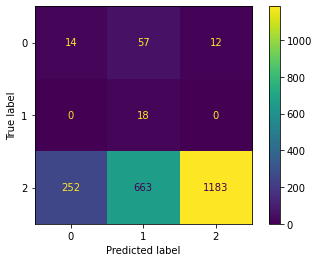

RNN Model:Accuracy of model(<3, = 3, >3) is:   [85.4  67.26 57.84]%
RNN Model:Sensitivity of the test(<3, = 3, >3):[ 16.87 100.    56.39]%
RNN Model:Specificity of the test(<3, = 3, >3):[88.09 66.99 88.12]%
RNN Model:Likelihood ratio(<3, = 3, >3):       [1.42 3.03 4.75]


In [31]:
## plot confusion matrix as well
cm = confusion_matrix(y_true, y_pred)
print(cm)
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.show()
accuracy, sensitivity, specificity, likelihood = contacts_utils.model_stats_all_labels(y_pred, y_true)
print(f'RNN Model:Accuracy of model(<3, = 3, >3) is:   {np.round(accuracy*100, 2)}%')
print(f'RNN Model:Sensitivity of the test(<3, = 3, >3):{np.round(sensitivity*100,2)}%')
print(f'RNN Model:Specificity of the test(<3, = 3, >3):{np.round(specificity*100,2)}%')
print(f'RNN Model:Likelihood ratio(<3, = 3, >3):       {np.round(likelihood, 2)}')

### Plot loss and validation, accuracy errors

In [32]:
print(history_embedding.history)

{'loss': [1.0648220777511597, 0.9925411343574524, 0.9329174757003784, 0.884126603603363, 0.8730056881904602, 0.8965586423873901, 0.8551949858665466, 0.8764827251434326, 0.8057549595832825, 0.7705609202384949, 0.8204777836799622], 'accuracy': [0.5612616539001465, 0.6522442102432251, 0.7393853664398193, 0.7456530332565308, 0.7135058641433716, 0.6953093409538269, 0.7359482645988464, 0.727254331111908, 0.7604124546051025, 0.7456530332565308, 0.7076425552368164], 'val_loss': [0.836064875125885, 0.7746328115463257, 0.9402700066566467, 0.642956018447876, 0.6282882690429688, 0.5004377961158752, 0.6555503606796265, 0.6568272113800049, 0.8325866460800171, 0.6800709366798401, 0.8747988939285278], 'val_accuracy': [0.7556094527244568, 0.8023044466972351, 0.7052759528160095, 0.8247422575950623, 0.8483929634094238, 0.8562765121459961, 0.7926015853881836, 0.8132201433181763, 0.7192237973213196, 0.797452986240387, 0.6470588445663452]}


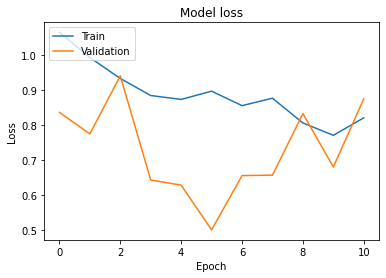

In [33]:
contacts_utils.plot_loss(history_embedding)

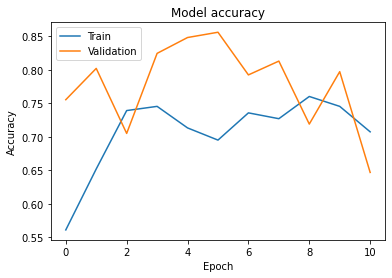

In [34]:
contacts_utils.plot_accuracy(history_embedding)

In [35]:
best_model

### Input test data as shown to determine sentiment based on best RNN model

* Input data also must be pre-processed into tokens before feeding into RNN model

In [36]:
import testdata_prep_rnn as tnn
import pandas as pd
filename = "data/Master-data_Q42021.xlsx"
print(f"Read sheet 'Scrubbed_data' ...")
df_raw = pd.read_excel(filename, sheet_name='Scrubbed_data', index_col='REVIEW_DATE')
# to get a subset as a dataframe, use double bracket notation
some_test_data = df_raw.iloc[:42, :]
some_test_data.columns

tks, wt = tnn.process_test_data(some_test_data, gensim_model)

Read sheet 'Scrubbed_data' ...
Columns dropped: ['OVERALL_RATING', 'COMFORT_RATING', 'VISION_RATING', 'VALUE_FOR_MONEY', 'PROS', 'CONS', 'ORIGINAL_SOURCE', 'REPLY_FROM_ACCUVUE', 'PRODUCT_LINK', 'WEBSITE']
 Drop the Author column and replace it with gender of author ...
Consolidate all the comments into one column called COMMENT
Make ratings into integers
Tokenize data based on regex found from experimentation and common usage ...
Comments before tokenization at index[0]:
 Acucue 2 Contact Lenses I have used these lenses for a long time and I have to say that the service from Lens.com is great and the lenses work great for my needs!  I highly recommend them!
Comments after tokenization at index[0]:
 Acucue 2 Contact Lenses I have used these lenses for a long time and I have to say that the service from Lens.com is great and the lenses work great for my needs!  I highly recommend them!
Comments at index[0] before basic cleaning:
 Acucue 2 Contact Lenses I have used these lenses for a lon

In [37]:
tp_raw = best_model.predict(tks)

2/2 [==============================] - 2s 100ms/step


In [38]:
y_test_pred = np.argmax(tp_raw, axis = 1)
y_test_pred

array([1, 0, 1, 1, 2, 2, 2, 2, 1, 1, 1, 0, 0, 2, 2, 1, 0, 1, 2, 0, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2])